<a href="https://colab.research.google.com/github/mgm22/official2020/blob/master/Mad_GANs_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MAD GAN

In [2]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import random
from random import randint
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [1]:
pip install scikit-learn==0.19.2

     |████████████████████████████████| 4.9MB 5.8MB/s 
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
# defining parameters for the training
mb_size = 128 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-4    # Learning Rate
num_gen = 4

In [5]:
np.random.seed(1)
gmm = GMM(5)
gmm.means_ = np.array([[10], [20], [60], [80], [110]])
gmm.covars_ = np.array([[3], [3], [2], [2], [1]]) ** 2
gmm.weights_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

X = gmm.sample(200000)
data = X
data = (data - X.min())/(X.max()-X.min())
#plt.hist(data, 200000, normed=False, histtype='stepfilled', alpha=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
G = []
for i in range(num_gen):
    G.append(torch.nn.Sequential(
        torch.nn.Linear(Z_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, X_dim),
        torch.nn.Sigmoid()
    ).cuda())

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, num_gen + 1),
    torch.nn.Softmax()
).cuda()

In [7]:
G_solver = []
for i in range(num_gen):
    G_solver.append(optim.Adam(G[i].parameters(), lr))
D_solver = optim.Adam(D.parameters(), lr)
###
loss = nn.CrossEntropyLoss()
label_G = Variable(torch.LongTensor(mb_size))
label_G = label_G.to(device)
label_D = Variable(torch.LongTensor(mb_size))
label_D = label_D.to(device)

In [8]:
# Reset the gradients to zero
params = [G[0], G[1], G[2], G[3], D]
def reset_grad():
    for net in params:
        net.zero_grad()
reset_grad()

In [10]:
print(G)
print(D)

[Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
), Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
), Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
), Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): PReLU(num_paramet

In [11]:
data_index = 0
for it in range(198000):
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0

    X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
    X = X.view(mb_size, 1)
    X = X.type(torch.FloatTensor)
    X = X.to(device)
    Total_D_loss = 0
    for i in range(num_gen):
        # Dicriminator forward-loss-backward-update
        #forward pass
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_real = D(X)
        D_fake = D(G_sample)
        # Calculate the loss
        D_loss_real = loss(D_real,label_D.fill_(num_gen + 0.1*randint(-1,1)))
        D_loss_fake = loss(D_fake, label_G.fill_(i + 0.1*randint(-1,1)))
        D_loss = D_loss_real + D_loss_fake
        Total_D_loss = D_loss + Total_D_loss
        # Calulate and update gradients of discriminator
        D_loss.backward()
        D_solver.step()

        # reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    
    Total_G_loss = 0
    for i in range(num_gen):
        
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_fake = D(G_sample)

        G_loss = loss(D_fake, label_D.fill_(num_gen + 0.1*randint(-1,1)))
        Total_G_loss = G_loss + Total_G_loss
        G_loss.backward()
        G_solver[i].step()

        # reset gradient
        reset_grad()
        
    data_index = data_index + 1
    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, Total_D_loss.data.cpu().numpy(), Total_G_loss.data.cpu().numpy()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iter-0; D_loss: 12.877647399902344; G_loss: 6.414348125457764
Iter-1000; D_loss: 12.121740341186523; G_loss: 5.436680793762207
Iter-2000; D_loss: 12.663895606994629; G_loss: 5.111286640167236
Iter-3000; D_loss: 11.78495979309082; G_loss: 6.265835285186768
Iter-4000; D_loss: 12.991355895996094; G_loss: 5.523771286010742
Iter-5000; D_loss: 11.889249801635742; G_loss: 5.163941383361816
Iter-6000; D_loss: 12.41379451751709; G_loss: 5.195889949798584
Iter-7000; D_loss: 12.319002151489258; G_loss: 5.25251579284668
Iter-8000; D_loss: 12.28233528137207; G_loss: 5.342812538146973
Iter-9000; D_loss: 12.237682342529297; G_loss: 5.1449785232543945
Iter-10000; D_loss: 11.337226867675781; G_loss: 5.218575477600098
Iter-11000; D_loss: 12.183147430419922; G_loss: 5.902035236358643
Iter-12000; D_loss: 13.100282669067383; G_loss: 5.2783403396606445
Iter-13000; D_loss: 11.565970420837402; G_loss: 5.058351516723633
Iter-14000; D_loss: 11.474931716918945; G_loss: 5.139024257659912
Iter-15000; D_loss: 12.13

 Let us see the images generated by the generator:

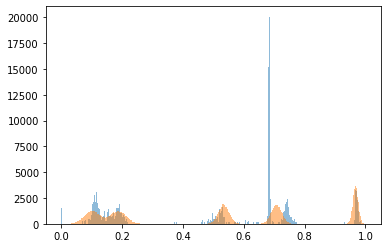

In [19]:
import numpy as np
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):
    z = torch.FloatTensor(64, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    l = G[randint(0,num_gen-1)](z).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]
p1 = plt.hist(final, 500, alpha = 0.5)
p2 = plt.hist(data, 500, alpha = 0.5)